In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.autograd import Variable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 150
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
#hyper parameters 

input_size = 11
hidden_size_1 = 128
hidden_size_2 = 256
hidden_size_3 = 512
hidden_size_4 = 512
hidden_size_5 = 256
hidden_size_6 = 128
output_size = 1

learning_rate  = 0.001
num_epochs = 1000
batch_size = 100
dropout = 0.65

In [3]:
#Data loading

class AirMeteoroPatientDataset(Dataset):

    def __init__(self):
        xy = pd.read_csv('Darussalam All year(generated, processed).csv')
        self.len = xy.shape[0]
        self.X_data = torch.from_numpy(xy.iloc[:,1:12].values)
        self.y_data = torch.from_numpy(xy.iloc[:,12:13].values)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [4]:
# Dataset creation and normalization

dataset = AirMeteoroPatientDataset()
dataset_inp = dataset.X_data
means = torch.mean(dataset_inp, dim=0, keepdim=True) # Computing mean across the data points. This results in a ndarray of size [1, 10]
std = torch.std(dataset_inp, dim=0, keepdim=True)   # Same as before

dataset.X_data = (dataset_inp - means) / std

In [5]:
#Dataset split

train_size = round(len(dataset) * 0.6)
val_size = round((len(dataset) - train_size)/2)
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(dataset,[train_size, val_size, test_size])

In [6]:
#making mini-batches for training set

train_loader = DataLoader(dataset = train_set,
                          batch_size = batch_size,
                          shuffle = True)

In [7]:
#model building

class Model(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, hidden_size_5, hidden_size_6, output_size, p = 0.0):
        super(Model, self).__init__()
        
        #linear_layers
        self.linear1 = nn.Linear(in_features = input_size, out_features = hidden_size_1, bias = True)
        self.linear2 = nn.Linear(in_features = hidden_size_1, out_features = hidden_size_2, bias = True)
        self.linear3 = nn.Linear(in_features = hidden_size_2, out_features = hidden_size_3, bias = True)
        self.linear4 = nn.Linear(in_features = hidden_size_3, out_features = hidden_size_4, bias = True)
        self.linear5 = nn.Linear(in_features = hidden_size_4, out_features = hidden_size_5, bias = True)
        self.linear6 = nn.Linear(in_features = hidden_size_5, out_features = hidden_size_6, bias = True)
        self.linear7 = nn.Linear(in_features = hidden_size_6, out_features = output_size, bias = True)
        
        #dropouts
        self.dropout = nn.Dropout(p = p)
        
        #activation
        self.relu = nn.ReLU()
        
        #batchnorm
        self.batchnorm1 = nn.BatchNorm1d(num_features = hidden_size_1)
        self.batchnorm2 = nn.BatchNorm1d(num_features = hidden_size_2)
        self.batchnorm3 = nn.BatchNorm1d(num_features = hidden_size_3)
        self.batchnorm4 = nn.BatchNorm1d(num_features = hidden_size_4)
        self.batchnorm5 = nn.BatchNorm1d(num_features = hidden_size_5)
        self.batchnorm6 = nn.BatchNorm1d(num_features = hidden_size_6)
        
        
    def forward(self, X):
        z1 = self.linear1(X)
        a1 = self.dropout(self.relu(self.batchnorm1(z1)))
        
        z2 = self.linear2(a1)
        a2 = self.dropout(self.relu(self.batchnorm2(z2)))
        
        z3 = self.linear3(a2)
        a3 = self.dropout(self.relu(self.batchnorm3(z3)))
        
        z4 = self.linear4(a3)
        a4 = self.dropout(self.relu(self.batchnorm4(z4)))
        
        z5 = self.linear5(a4)
        a5 = self.dropout(self.relu(self.batchnorm5(z5)))
        
        z6 = self.linear6(a5)
        a6 = self.dropout(self.relu(self.batchnorm6(z6)))
        
        out = self.linear7(a6)
        return out
    

In [8]:
#model initialization

model = Model(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, hidden_size_5, hidden_size_6, output_size, p= dropout).float().cuda()

In [9]:
#Loss function and optimizer

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [10]:
#itertaion and learning parameters

all_test_loss = []
all_val_loss = []
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    model.train()
    for i, (X_data, y_data) in enumerate(train_loader):  
       
        X_data = X_data.cuda()
        y_data = y_data.cuda()
        
        # Forward pass
        outputs = model(X_data.float())
        loss = criterion(outputs, y_data.float())
        
        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    if (epoch +1) % 50 == 0:
        print (f'Train loss after Epoch [{epoch+1}/{num_epochs}]: {loss.item():.6f}')
            
    all_test_loss.append(loss)
    
    X_val = torch.empty(0, 11).float().cuda()
    y_val = torch.empty(0,1).float().cuda()
    for i, (X_data, y_data) in enumerate(val_set):
        X_data = X_data.float().reshape(1,11).cuda()
        X_val = torch.cat((X_val, X_data), 0)
    
        y_data = y_data.float().reshape(1,1).cuda()
        y_val = torch.cat((y_val, y_data), 0)
        
    model.eval()
    
    with torch.no_grad():
        outputs = model(X_val).cuda()
        val_loss = criterion(outputs, y_val)
        all_val_loss.append(val_loss)

Train loss after Epoch [50/1000]: 17.055279
Train loss after Epoch [100/1000]: 10.224617
Train loss after Epoch [150/1000]: 14.192698
Train loss after Epoch [200/1000]: 10.156314
Train loss after Epoch [250/1000]: 13.449133
Train loss after Epoch [300/1000]: 14.400348
Train loss after Epoch [350/1000]: 10.223034
Train loss after Epoch [400/1000]: 12.232325
Train loss after Epoch [450/1000]: 11.600279
Train loss after Epoch [500/1000]: 9.396484
Train loss after Epoch [550/1000]: 11.307986
Train loss after Epoch [600/1000]: 18.273285
Train loss after Epoch [650/1000]: 10.821129
Train loss after Epoch [700/1000]: 9.903555
Train loss after Epoch [750/1000]: 10.727598
Train loss after Epoch [800/1000]: 9.681492
Train loss after Epoch [850/1000]: 13.845981
Train loss after Epoch [900/1000]: 16.080647
Train loss after Epoch [950/1000]: 12.545605
Train loss after Epoch [1000/1000]: 8.715652


Text(0, 0.5, 'Loss')

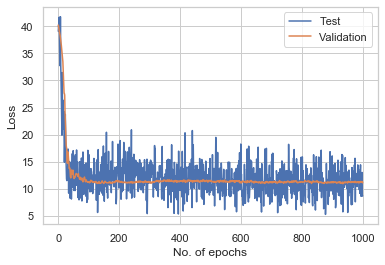

In [11]:
#test_val_plot     

plt.plot(list(range(0,epoch+1)), all_test_loss, label = 'Test')
plt.plot(list(range(0,epoch+1)), all_val_loss, label = 'Validation')
plt.legend(loc="upper right")
plt.xlabel('No. of epochs')
plt.ylabel('Loss')

In [12]:
#loading test set in tensors

X_test = torch.empty(0, 11).float().cuda()
y_test = torch.empty(0,1).float().cuda()
for i, (X_data, y_data) in enumerate(test_set):
    X_data = X_data.float().reshape(1,11).cuda()
    X_test = torch.cat((X_test, X_data), 0)
    
    y_data = y_data.float().reshape(1,1).cuda()
    y_test = torch.cat((y_test, y_data), 0)

In [13]:
#determining test set loss
with torch.no_grad():
    model.eval()
    outputs = model(X_test).cuda()
    test_loss = criterion(outputs, y_test)
    print('Total Test loss',test_loss.item())

Total Test loss 9.750640869140625


In [14]:
loss_MSE = nn.MSELoss()
loss_huber = nn.SmoothL1Loss()
MAEloss = criterion(outputs, y_test)
MSEloss = loss_MSE(outputs, y_test)
Huberloss = loss_huber(outputs, y_test)
print('Total MSE loss', MSEloss.item())
print('Total MAE loss', MAEloss.item())
print('Total Huber loss', Huberloss.item())

Total MSE loss 163.87112426757812
Total MAE loss 9.750640869140625
Total Huber loss 9.261853218078613
